# Ch06 Pandas DataFrame 特徵轉換

# Outline
- 各種編碼方式
- 特徵數值轉換

## Categorical encoding in Feature Engineering
- One-Hot encoding (OHE)
- Ordinal encoding
- Count and Frequency encoding
- Target encoding / Mean encoding




[參考](https://axk51013.medium.com/%E4%B8%8D%E8%A6%81%E5%86%8D%E5%81%9Aone-hot-encoding-b5126d3f8a63)

## 建立測試資料

In [57]:
import pandas as pd

# 示例数据集
data = {
    'Category': ['A', 'B', 'A', 'C', 'B', 'A', 'D', 'E'],
    'Target': [1, 0, 0, 1, 1, 0, 1, 0]
}
df = pd.DataFrame(data)

df

,Category,Target
0,A,1
1,B,0
2,A,0
3,C,1
4,B,1
5,A,0
6,D,1
7,E,0


## 編碼介紹

### 獨熱編碼（One-Hot Encoding）

- 使用場景：類別之間沒有固定順序時
- 優點：避免模型錯誤理解數值順序
- 缺點：可能導致維度爆炸，特別是在類別數量較多時

In [58]:
# OHE 方法一
df_one_hot = pd.get_dummies(df, columns=['Category'], prefix='Cat')
df_one_hot = df_one_hot.astype(int)

print(df_one_hot)

   Target  Cat_A  Cat_B  Cat_C  Cat_D  Cat_E
0       1      1      0      0      0      0
1       0      0      1      0      0      0
2       0      1      0      0      0      0
3       1      0      0      1      0      0
4       1      0      1      0      0      0
5       0      1      0      0      0      0
6       1      0      0      0      1      0
7       0      0      0      0      0      1


In [59]:
# OHE 方法二
from sklearn.preprocessing import OneHotEncoder

# 初始化 OneHotEncoder
encoder = OneHotEncoder()  # 默認 sparse=True

# 物件編碼
encoded_data = encoder.fit_transform(df[['Category']]).toarray()  # 使用.toarray() 轉換為 sparse matrix

# 編碼後轉換回 DataFrame
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['Category']))

# 將編碼後的 DataFrame 附加回原始DataFrame
df_encoded = pd.concat([df, encoded_df], axis=1)

print(df_encoded)


  Category  Target  Category_A  Category_B  Category_C  Category_D  Category_E
0        A       1         1.0         0.0         0.0         0.0         0.0
1        B       0         0.0         1.0         0.0         0.0         0.0
2        A       0         1.0         0.0         0.0         0.0         0.0
3        C       1         0.0         0.0         1.0         0.0         0.0
4        B       1         0.0         1.0         0.0         0.0         0.0
5        A       0         1.0         0.0         0.0         0.0         0.0
6        D       1         0.0         0.0         0.0         1.0         0.0
7        E       0         0.0         0.0         0.0         0.0         1.0


### 字典編碼（dict_mapping Encoding）

- 使用場景：類別之間沒有固定順序時
- 優點：自定義標籤，不會增加數據維度
- 缺點：數字大小有意義，可以給權重，但是在一些模型中，可被視為初始有大小關係

In [60]:
label_mapping = {
    'A': 10,
    'B': 20,
    'C': 30,
    'D': 40,
    'E': 50
}

df['Category_Label_Encoded'] = df['Category'].map(label_mapping)
print(df[['Category', 'Target', 'Category_Label_Encoded']])




  Category  Target  Category_Label_Encoded
0        A       1                      10
1        B       0                      20
2        A       0                      10
3        C       1                      30
4        B       1                      20
5        A       0                      10
6        D       1                      40
7        E       0                      50


### 標籤編碼（Label Encoding）

- 使用場景：類別間存在自然排序關係（如高、中、低）
- 優點：簡單易於實施
- 缺點：可能導致模型誤解數據，錯誤地解讀類別間的數值關係

In [61]:
# 方法一
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Category_Label_Encoded'] = le.fit_transform(df['Category'])
print(df[['Category', 'Target', 'Category_Label_Encoded']])



  Category  Target  Category_Label_Encoded
0        A       1                       0
1        B       0                       1
2        A       0                       0
3        C       1                       2
4        B       1                       1
5        A       0                       0
6        D       1                       3
7        E       0                       4


In [62]:
# 方法二

df['Catagorical_label'] = pd.Categorical(df['Category']).codes
print(df[['Category', 'Target', 'Catagorical_label']])



  Category  Target  Catagorical_label
0        A       1                  0
1        B       0                  1
2        A       0                  0
3        C       1                  2
4        B       1                  1
5        A       0                  0
6        D       1                  3
7        E       0                  4


### 序列編碼（Ordinal Encoding）等價 標籤編碼（Label Encoding）

- 使用場景：存在明確排序的類別特徵
- 優點：能夠直接反映類別之間的順序關係
- 缺點：需手動設定順序，可能會增加預處理工作量

In [63]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
df['Category_Ordinal_Encoded'] = ordinal_encoder.fit_transform(df[['Category']])
print(df[['Category', 'Target', 'Category_Ordinal_Encoded']])



  Category  Target  Category_Ordinal_Encoded
0        A       1                       0.0
1        B       0                       1.0
2        A       0                       0.0
3        C       1                       2.0
4        B       1                       1.0
5        A       0                       0.0
6        D       1                       3.0
7        E       0                       4.0


### 頻率編碼（Frequency Encoding）

- 使用場景：類別重要性與其出現頻率成正比時
- 優點：保留了類別出現頻率的信息
- 缺點：不同類別可能有相同的頻率值

In [64]:
frequency = df['Category'].value_counts().to_dict()
df['Category_Frequency'] = df['Category'].map(frequency)
print(df[['Category', 'Target', 'Category_Frequency']])


  Category  Target  Category_Frequency
0        A       1                   3
1        B       0                   2
2        A       0                   3
3        C       1                   1
4        B       1                   2
5        A       0                   3
6        D       1                   1
7        E       0                   1


### 目標編碼（Target Encoding）

- 使用場景：分類問題中，類別特徵與目標變量之間存在關聯
- 優點：能夠捕捉類別與目標變量之間的關系
- 缺點：容易導致過擬合，需注意避免數據洩露


只要使用從預測目標提取出來的資訊，來取代類別特徵，這種方法都被稱為Target encoding。

有一個最簡單有效的方法為，分組聚合(group aggregation)，將 dataset 依據各類別分組統計，並取平均，讓每個類別都用自己的平均值取代。

#### 注意事項:

雙重驗證（Double Validation）通常意味著在進行目標編碼時，會將數據分兩部分：
一部分用於計算編碼，另一部分用應用編碼和訓練模型，這樣可以確保編碼不會用到訓練數據中的任何訊息

[參考](https://medium.com/@seikimaii_Huang/%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92%E7%AD%86%E8%A8%98-target-encoding-1b585d8ee8ab)

In [65]:
df['Category_maked_by_Target'] = df.groupby("Category")["Target"].transform("mean")
print(df[['Category', 'Target','Category_maked_by_Target']])


  Category  Target  Category_maked_by_Target
0        A       1                  0.333333
1        B       0                  0.500000
2        A       0                  0.333333
3        C       1                  1.000000
4        B       1                  0.500000
5        A       0                  0.333333
6        D       1                  1.000000
7        E       0                  0.000000


In [66]:
# category_encoders 套件參考 Categorical Encoders and Benchmark
# https://www.kaggle.com/code/subinium/11-categorical-encoders-and-benchmark

'''
category_encoders 提供的 TargetEncoder 有平滑處理，針對特定類別較少的情況，可以避免 overfitting 的問題
'''

import category_encoders as ce

target_encoder = ce.TargetEncoder(cols=['Category'])
df['Category_Target_Enc'] = target_encoder.fit_transform(df['Category'], df['Target'])
print(df[['Category', 'Target','Category_Target_Enc']])


  Category  Target  Category_Target_Enc
0        A       1             0.474256
1        B       0             0.500000
2        A       0             0.474256
3        C       1             0.565054
4        B       1             0.500000
5        A       0             0.474256
6        D       1             0.565054
7        E       0             0.434946


## 特徵數值轉換 Variable Transformation


- Logarithm transformation – log(x)
- Square root transformation – sqrt(x)
- Reciprocal transformation – 1 / x
- Exponential transformation – exp(x)

In [67]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pylab
import scipy.stats as stats

data = pd.read_csv("data/titanic.csv")
data.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [68]:
def impute_na(data, variable):
    df = data.copy()
    df[variable+'_random'] = df[variable]
    # extract the random sample to fill the na
    random_sample = df[variable].dropna().sample(df[variable].isnull().sum(), random_state=0) # 取出非空值隨機取樣

    random_sample.index = df[df[variable].isnull()].index
    df.loc[df[variable].isnull(), variable+'_random'] = random_sample
    
    return df[variable+'_random']

data['Age'] = impute_na(data, 'Age')


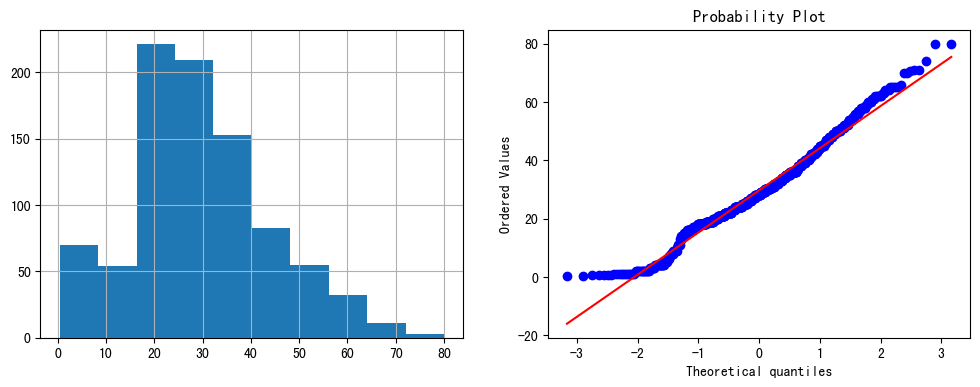

In [69]:
def plots(df, variable):
    plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    df[variable].hist()
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=pylab)
    plt.show()


plots(data, 'Age')

### Logarithmic transformation

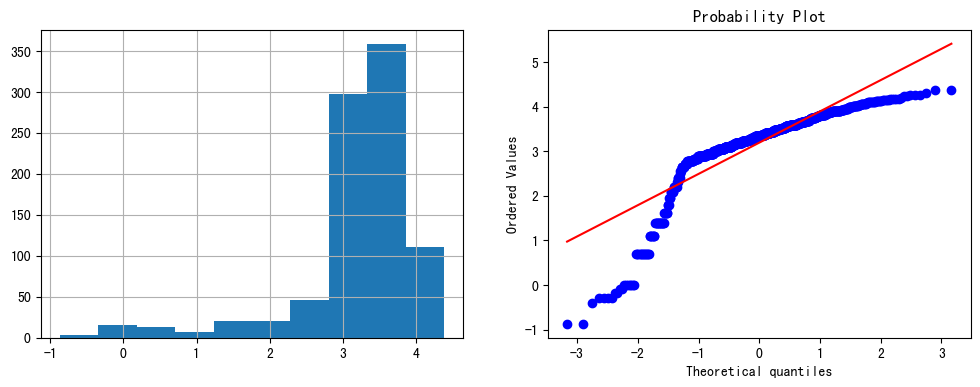

In [70]:
data['Age_log'] = np.log(data.Age)
plots(data, 'Age_log')

### Square root transformation – sqrt(x)

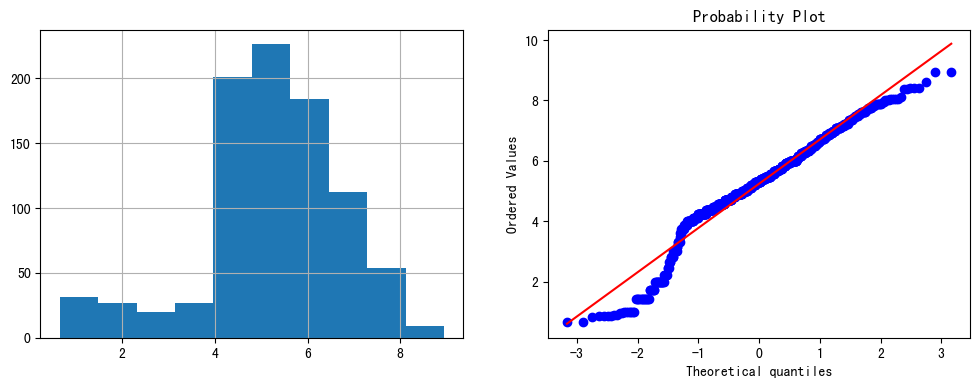

In [71]:
data['Age_sqr'] =data.Age**(1/2)
plots(data, 'Age_sqr')

### Reciprocal transformation – 1 / x

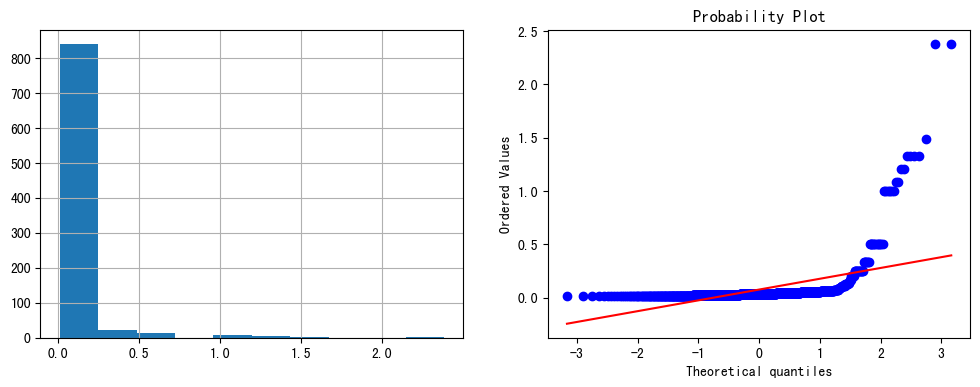

In [72]:
data['Age_reciprocal'] = 1 / data.Age
plots(data, 'Age_reciprocal')

### Exponential transformation – exp(x)

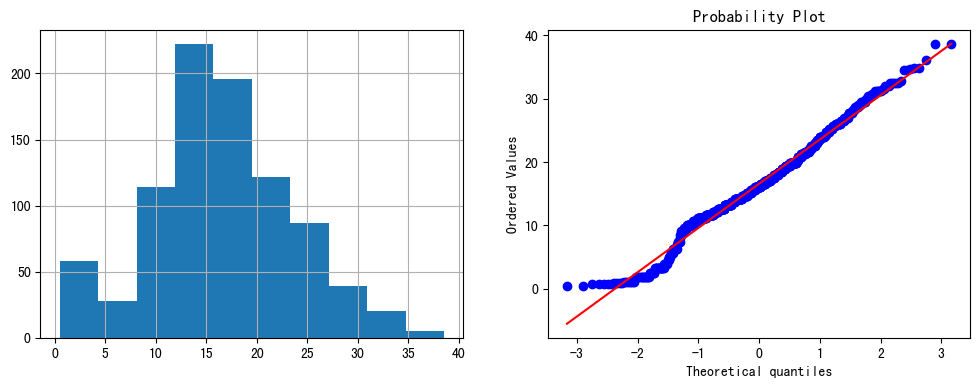

In [73]:
data['Age_exp'] = data.Age**(1/1.2) 
plots(data, 'Age_exp')


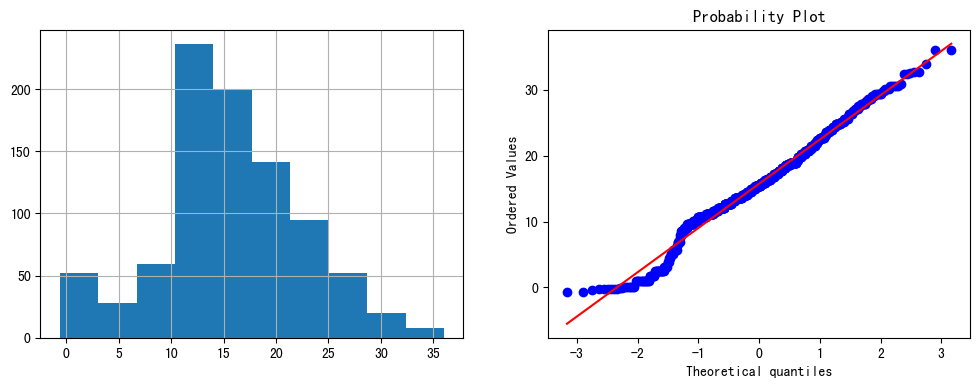

In [74]:
# 使用 Box-Cox 變換來嘗試修正這種偏態
data['Age_box-cox'] =stats.boxcox(data.Age)[0]
plots(data, 'Age_box-cox')


### 標準化（Standardization）
- 原理:將原始數據減去平均值並除以標準差,使所得資料平均值為0、標準差為1。
- 場景:適用於大多數的參數型機器學習演算法,如支撐向量機、羅吉斯回歸及線性回歸。這處理同一規模的數據時,效果較為優異。
- 注意事項:
    - 優點:可提升收斂速率,減少模型訓練時間。增加訓練穩定性。
    - 缺點:數據若明顯不服從正態分佈,標準化未必為好的選擇。

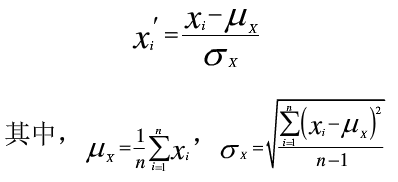

特點
1. 提高算法收斂速度：當所有特徵都被縮放到相同的尺度（均值為0，標準差為1），梯度下降之類的優化算法能夠更快地收斂到最佳解。這是因為特徵的尺度統一，避免了某些特徵在損失函數中占據主導地位，從而使梯度下降過程更加平衡。

2. 提高模型準確度：對於許多機器學習算法，如支持向量機（SVM）和K最近鄰（KNN），如果特徵處於相同的尺度，它們的性能通常會更好。這是因為標準化後的數據消除了特徵間尺度的差異，幫助這些基於距離的算法能夠更公平地衡量各特徵之間的相似性或差異。

3. 使數據符合模型假設：某些算法，如線性回歸，假設所有特徵都是正態分佈的，並且特徵之間相互獨立。通過標準化，可以使特徵更接近於正態分佈，特別是當原始數據大致符合正態分佈時，標準化可以增加模型的效果。

4. 避免數值不穩定和改善數值穩定性：在進行數學運算時，尤其是當特徵範圍差異很大時，未經處理的特徵可能導致數值計算問題，比如溢出或下溢。標準化可以減少這些問題，使得數值更加穩定。

使特徵之間可比較：在一些應用中，我們可能想要比較不同特徵的重要性或影響力。標準化後，所有特徵都處於同一尺度上。在比較上較容易

```ps: 並非所有機器學習模型都需要標準化。例如，基於樹的算法（如決策樹和隨機森林）通常不受特徵尺度的影響。```

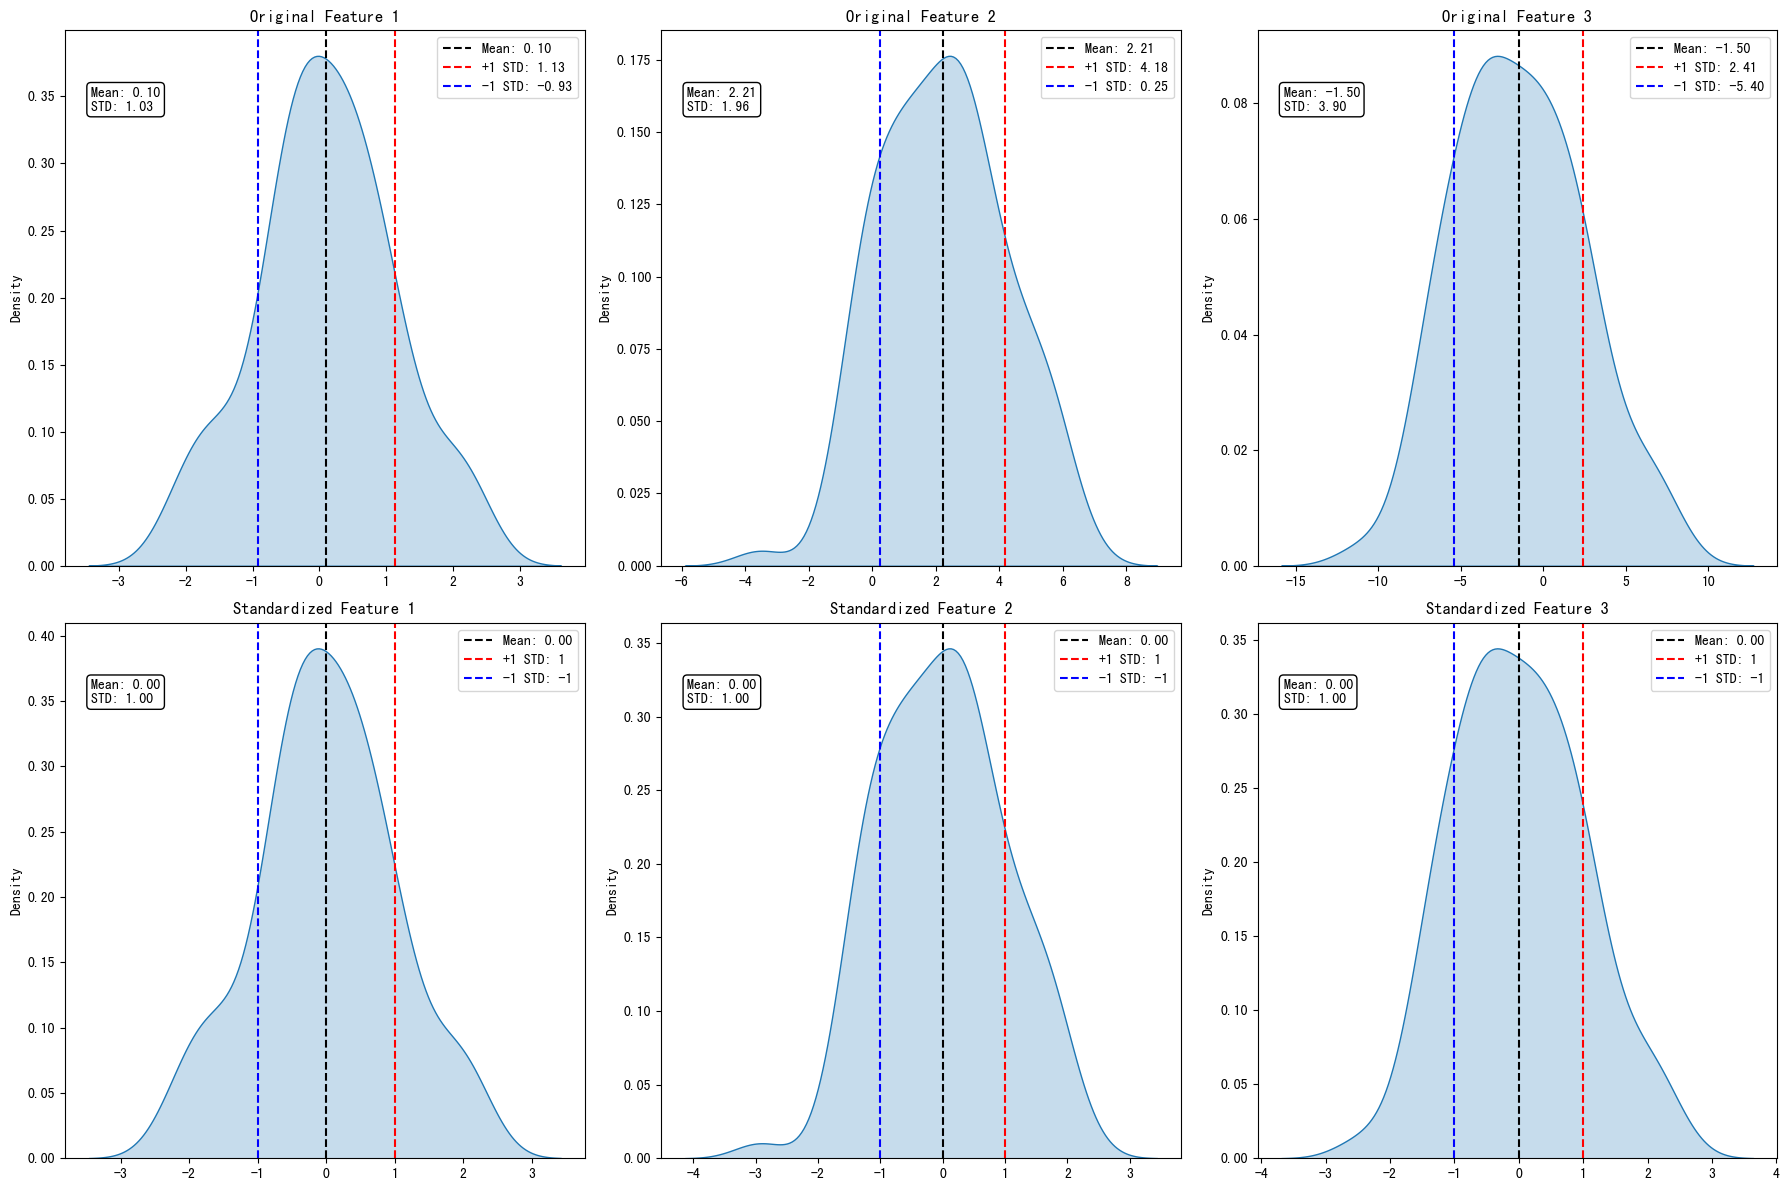

In [75]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Redesigning the data to demonstrate with KDE plots
# Let's create a slightly more varied dataset for a more interesting visualization.
np.random.seed(0)  # For reproducibility
X_new = np.random.randn(100, 3) * np.array([1, 2, 4]) + np.array([0, 2, -1])

# Standardizing the newly created dataset
scaler_new = StandardScaler()
X_new_scaled = scaler_new.fit_transform(X_new)

# Let's create a new visualization that clearly shows the original and standardized data, including labels for the mean and standard deviation.
# First, let's calculate the mean and standard deviation for both the original and standardized data.
means_orig = np.mean(X_new, axis=0)
stds_orig = np.std(X_new, axis=0)

means_scaled = np.mean(X_new_scaled, axis=0)
stds_scaled = np.std(X_new_scaled, axis=0)

# Now, let's plot KDEs with labels for mean and standard deviation.
fig, axs = plt.subplots(2, 3, figsize=(18, 12))


# Plotting the original data with 1-sigma lines
for i in range(3):
    sns.kdeplot(X_new[:, i], ax=axs[0, i], fill=True)
    axs[0, i].set_title(f'Original Feature {i+1}')
    axs[0, i].annotate(f'Mean: {means_orig[i]:.2f}\nSTD: {stds_orig[i]:.2f}', xy=(0.05, 0.85), xycoords='axes fraction', 
                       bbox=dict(boxstyle="round", fc="w"))
    axs[0, i].axvline(x=means_orig[i], color='k', linestyle='--', label=f'Mean: {means_orig[i]:.2f}')
    axs[0, i].axvline(x=means_orig[i]+stds_orig[i], color='r', linestyle='--', label=f'+1 STD: {means_orig[i]+stds_orig[i]:.2f}')
    axs[0, i].axvline(x=means_orig[i]-stds_orig[i], color='b', linestyle='--', label=f'-1 STD: {means_orig[i]-stds_orig[i]:.2f}')

# Plotting the standardized data with 1-sigma lines
for i in range(3):
    sns.kdeplot(X_new_scaled[:, i], ax=axs[1, i], fill=True)
    axs[1, i].set_title(f'Standardized Feature {i+1}')
    axs[1, i].annotate(f'Mean: {means_scaled[i]:.2f}\nSTD: {stds_scaled[i]:.2f}', xy=(0.05, 0.85), xycoords='axes fraction', 
                       bbox=dict(boxstyle="round", fc="w"))
    axs[1, i].axvline(x=means_scaled[i], color='k', linestyle='--', label=f'Mean: {means_scaled[i]:.2f}')
    # For standardized data, +1 STD and -1 STD lines will be at 1 and -1 respectively
    axs[1, i].axvline(x=1, color='r', linestyle='--', label='+1 STD: 1')
    axs[1, i].axvline(x=-1, color='b', linestyle='--', label='-1 STD: -1')

for ax in axs.flat:
    ax.legend()

plt.tight_layout()
plt.show()


### 歸一化（Normalization）
- 原理:將數據範圍縮放至特定最小及最大值(通常為0到1)之間。
- 場景:對於對數據絕對大小敏感的演算法,如神經網路,歸一化十分有用。
- 注意事項:
    - 優點:令各特徵的權重平等。
    - 缺點:若數據含異常值,歸一化可能會壓縮正常數據空間。

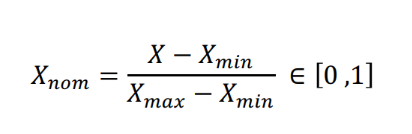

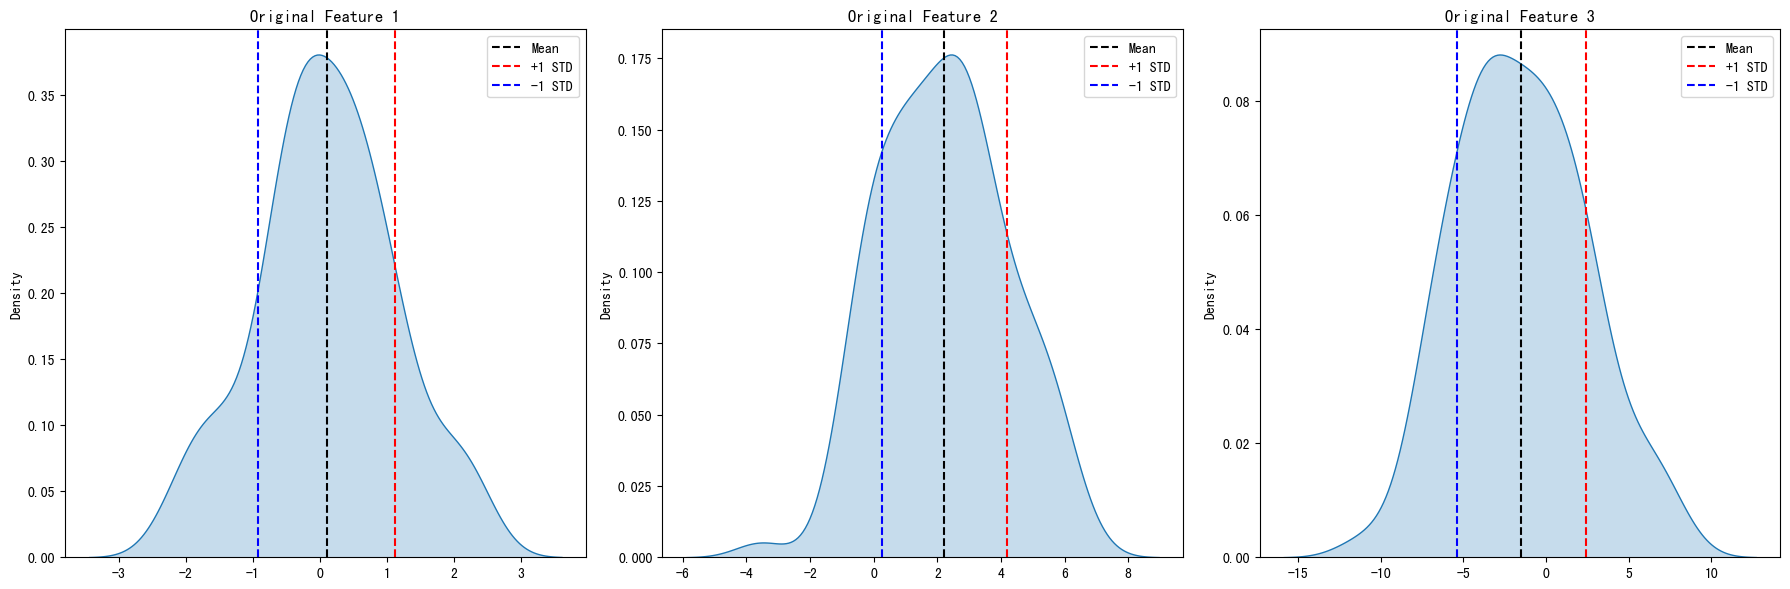

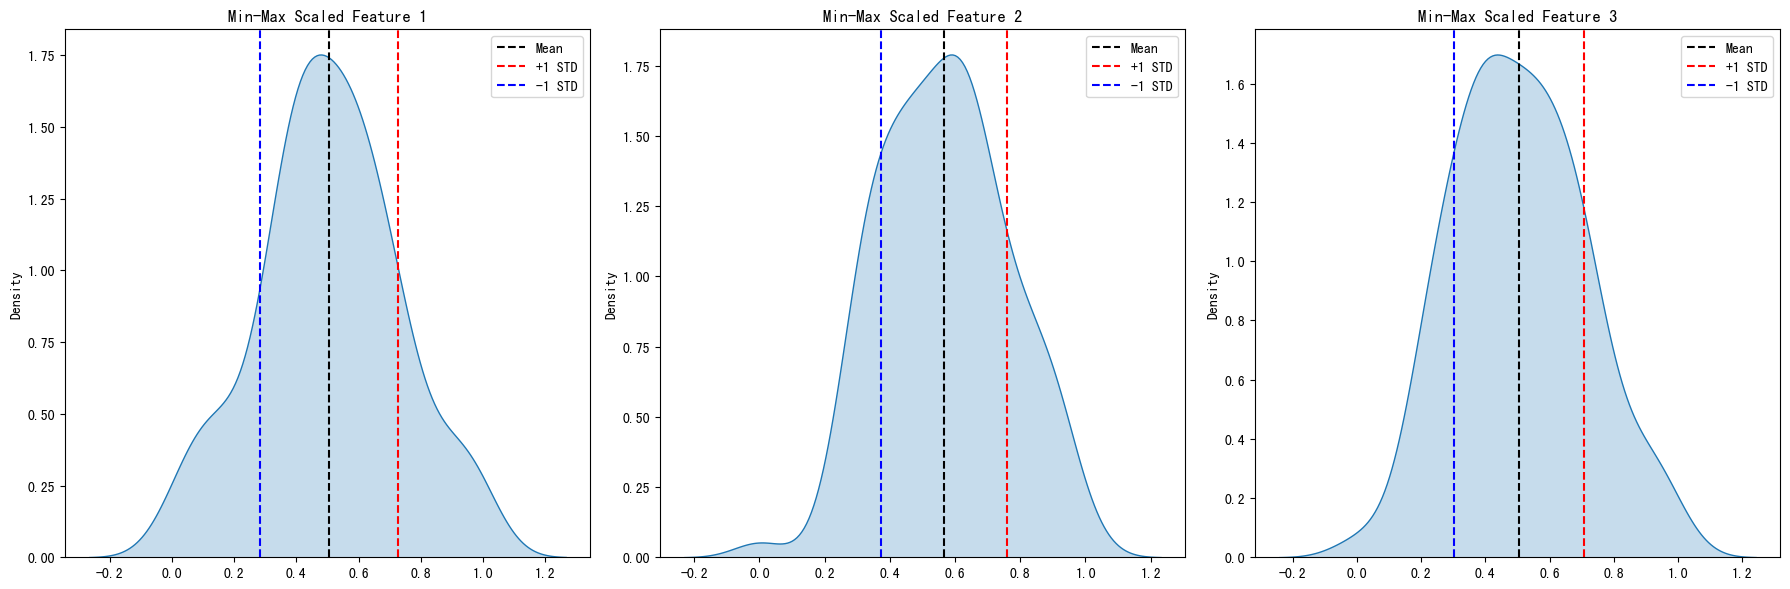

In [76]:
from sklearn.preprocessing import MinMaxScaler

# Redefining the dataset as specified
np.random.seed(0)
X_new = np.random.randn(100, 3) * np.array([1, 2, 4]) + np.array([0, 2, -1])

means = np.mean(X_new, axis=0)
stds = np.std(X_new, axis=0)

# Applying MinMaxScaler to the dataset
scaler_min_max = MinMaxScaler()
X_new_min_max_scaled = scaler_min_max.fit_transform(X_new)

# Calculating means and standard deviations for the min-max scaled data
means_min_max_scaled = np.mean(X_new_min_max_scaled, axis=0)
stds_min_max_scaled = np.std(X_new_min_max_scaled, axis=0)

# Attempting KDE visualization for MinMax scaled data
# KDE visualization for original data
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for i in range(3):
    sns.kdeplot(X_new[:, i], ax=axs[i], fill=True)
    axs[i].set_title(f'Original Feature {i+1}')
    axs[i].axvline(x=means[i], color='k', linestyle='--', label='Mean')
    axs[i].axvline(x=means[i]+stds[i], color='r', linestyle='--', label='+1 STD')
    axs[i].axvline(x=means[i]-stds[i], color='b', linestyle='--', label='-1 STD')
    axs[i].legend()

plt.tight_layout()
plt.show()

# KDE visualization for Min-Max scaled data
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for i in range(3):
    sns.kdeplot(X_new_min_max_scaled[:, i], ax=axs[i], fill=True)
    axs[i].set_title(f'Min-Max Scaled Feature {i+1}')
    axs[i].axvline(x=means_min_max_scaled[i], color='k', linestyle='--', label='Mean')
    axs[i].axvline(x=means_min_max_scaled[i]+stds_min_max_scaled[i], color='r', linestyle='--', label='+1 STD')
    axs[i].axvline(x=means_min_max_scaled[i]-stds_min_max_scaled[i], color='b', linestyle='--', label='-1 STD')
    axs[i].legend()

plt.tight_layout()
plt.show()


## 箱型變換（Box-Cox）
- 原理:一種變換技術,尋找參數λ使數據更貼近正態分佈,是對數變換的推廣。
- 場景:適用於連續響應變數需符合線性回歸模型假設的情況。
- 注意事項:
    - 優點:能處理更多類型的偏態分佈。
    - 缺點:需要正值數據,且計算較為繁複。

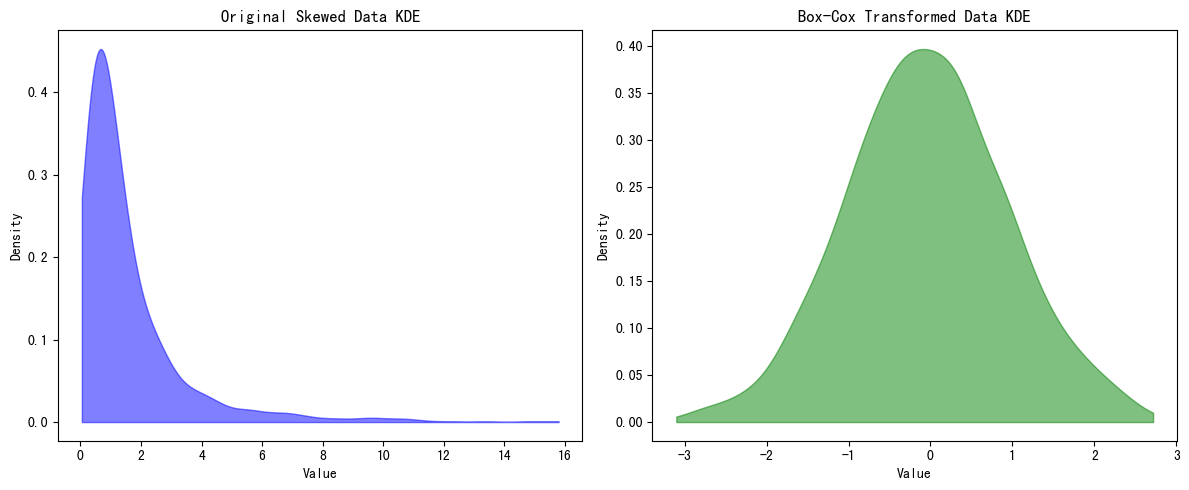

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# 生成具有明顯偏態的數據（我們可以使用對數正態分佈）
np.random.seed(0)  # 為了結果的一致性
skewed_data = np.random.lognormal(mean=0, sigma=1, size=1000)

# 使用 Box-Cox 變換來嘗試修正這種偏態
transformed_data, best_lambda = stats.boxcox(skewed_data)

# 計算原始數據和變換後數據的 KDE
kde_orig = stats.gaussian_kde(skewed_data)
kde_transformed = stats.gaussian_kde(transformed_data)

# 生成圖的 x 軸數據點
x_orig = np.linspace(skewed_data.min(), skewed_data.max(), 1000)
x_transformed = np.linspace(transformed_data.min(), transformed_data.max(), 1000)

# 繪製圖形
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 原始數據的 KDE
axes[0].fill_between(x_orig, kde_orig(x_orig), color='blue', alpha=0.5)
axes[0].set_title('Original Skewed Data KDE')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Density')

# 變換後數據的 KDE
axes[1].fill_between(x_transformed, kde_transformed(x_transformed), color='green', alpha=0.5)
axes[1].set_title('Box-Cox Transformed Data KDE')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Density')

plt.tight_layout()
plt.show()


